In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import torch
import torch.nn as nn
import random
import cv2
from tqdm import tqdm

In [2]:
ACTIONS = {
0: np.array([0.0, 0.0, 0.0], dtype=np.float64),
1: np.array([1.0, 0.0, 0.0], dtype=np.float64),
2: np.array([-1.0, 0.0, 0.0], dtype=np.float64),
3: np.array([0.0, 1.0, 0.0], dtype=np.float64),
4: np.array([0.0, 0.0, 0.5], dtype=np.float64)
}

N_ACTIONS = len(ACTIONS)

In [3]:
def preprocess(obs):
    gray = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
    resized = cv2.resize(gray, (64, 64))
    normalized = resized / 255.0
    return normalized

In [9]:
class DQN(nn.Module):
    def __init__(self, n_actions):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4
                      , stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        self.fc = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [12]:
print(DQN(4))

DQN(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=4, bias=True)
  )
)


In [ ]:
frame_stack = deque(maxlen=4)

def get_state(obs):
    frame = preprocess(obs)
    frame_stack.append(frame)
    while len(frame_stack) < 4:
        frame_stack.append(frame)
    return np.stack(frame_stack, axis=0)  # (4, 84, 84)


In [ ]:
class ReplayMemory(): 
    def __init__(self, maxlen):
        self.memory = deque([], maxlen=maxlen) 
    def append(self, transition): 
        self.memory.append(transition) 
    def sample(self, sample_size): 
        return random.sample(self.memory, sample_size) 
    def __len__(self): 
        return len(self.memory)

In [ ]:
rewards_per_episode = []

def train(episodes):
    env = gym.make('CarRacing-v3', render_mode=None, max_episode_steps=300)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    policy_net = DQN(N_ACTIONS).to(device)
    target_net = DQN(N_ACTIONS).to(device)

    target_net.load_state_dict(policy_net.state_dict())

    optimizer = torch.optim.Adam(policy_net.parameters(), lr=1e-4)
    memory = ReplayMemory(10000)

    epsilon = 1.0 # Initial exploration rate
    epsilon_min = 0.05 
    epsilon_decay = 0.995
    gamma = 0.99 # Discount factor
    batch_size = 32
    sync_rate = 1000 # How often to update target network
    step_count = 0
    TRAIN_EVERY = 16
    best_reward = -float("inf")

    for episode in tqdm(range(episodes)):
        obs, _ = env.reset()
        frame_stack.clear()
        state = get_state(obs)

        done = False
        total_reward = 0

        while not done:
            if(random.random() < epsilon):
                action_idx = random.randrange(N_ACTIONS)
            else:
                with torch.no_grad():
                    q = policy_net(torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device))
                    action_idx = q.argmax().item()
            
            next_obs, reward, terminated, truncated, _ = env.step(ACTIONS[action_idx])
            done = terminated or truncated
            next_state = get_state(next_obs)
            memory.append((state, action_idx, reward, next_state, done))
            state = next_state
            total_reward += reward
            step_count += 1

            if len(memory) >= batch_size and step_count % TRAIN_EVERY == 0:
                batch = memory.sample(batch_size)
                states, actions, rewards, next_states, done_stuff = zip(*batch) # separate batch elements into 5 tuples
                states = torch.tensor(states, dtype=torch.float32).to(device) # shape: (batch_size, 4, 84, 84)
                actions = torch.tensor(actions).unsqueeze(1).to(device) # shape: (batch_size, 1)
                rewards = torch.tensor(rewards).to(device) # shape: (batch_size)
                next_states = torch.tensor(next_states, dtype=torch.float32).to(device) # shape: (batch_size, 4, 84, 84)
                done_stuff = torch.tensor(done_stuff, dtype=torch.float32).to(device) # shape: (batch_size)

                q_values = policy_net(states).gather(1, actions).squeeze(1) # shape: (batch_size)
                next_q_values = target_net(next_states).max(1)[0] # shape: (batch_size)
                target = rewards + gamma * next_q_values * (1 - done_stuff)

                loss = torch.nn.functional.mse_loss(q_values, target.detach())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            if step_count % sync_rate == 0:
                target_net.load_state_dict(policy_net.state_dict())
        
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        rewards_per_episode.append(total_reward)
        tqdm.write(f"Episode {episode+1}, Total Reward: {total_reward}, Epsilon: {epsilon:.3f}")
        if total_reward > best_reward:
            best_reward = total_reward
            torch.save(policy_net.state_dict(), "models/dqn_carracing_best.pt")
    env.close()

                    

In [ ]:
train(800)

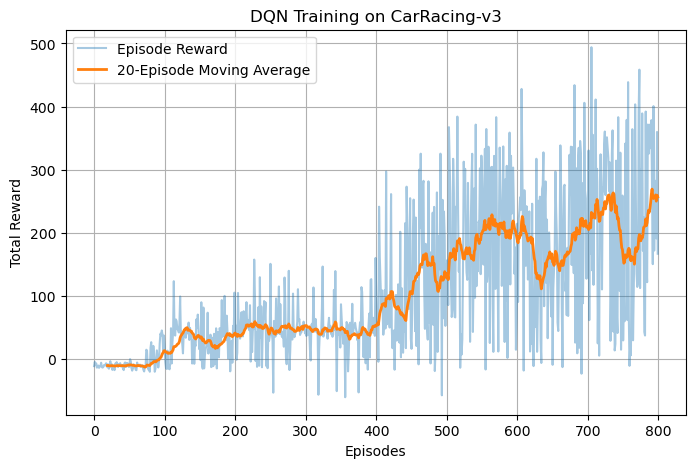

In [24]:
plt.figure(figsize=(8, 5))
plt.plot(rewards_per_episode, label="Episode Reward", alpha=0.4)

# Moving average for smoothing
window = 20
if len(rewards_per_episode) >= window:
    moving_avg = np.convolve(
        rewards_per_episode,
        np.ones(window)/window,
        mode="valid"
    )
    plt.plot(
        range(window-1, len(rewards_per_episode)),
        moving_avg,
        label=f"{window}-Episode Moving Average",
        linewidth=2
    )

plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("DQN Training on CarRacing-v3")
plt.legend()
plt.grid(True)
plt.show()


In [27]:
def evaluate_model(model_path, episodes=100, seed=42):
    env = gym.make("CarRacing-v3", render_mode=None, max_episode_steps=300)
    env.reset(seed=seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    policy_net = DQN(N_ACTIONS).to(device)
    policy_net.load_state_dict(torch.load(model_path))
    policy_net.eval()

    episode_rewards = []
    for episode in tqdm(range(episodes)):
        obs, _ = env.reset()
        frame_stack.clear()
        state = get_state(obs)
        done = False
        total_reward = 0.0

        while not done:
            with torch.no_grad():
                q_values = policy_net(torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device))
                action_idx = q_values.argmax().item()
            next_obs, reward, terminated, truncated, _ = env.step(ACTIONS[action_idx])
            done = terminated or truncated
            state = get_state(next_obs)
            total_reward += reward
        
        episode_rewards.append(total_reward)
    env.close()

    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)

    print(f"Evaluation over {episodes} episodes: Mean Reward = {mean_reward}, Std Dev = {std_reward}")

    return mean_reward, std_reward


In [ ]:
mean_reward, std_reward = evaluate_model("models/dqn_carracing_best.pt", episodes=100, seed=42)

100%|██████████| 100/100 [08:53<00:00,  5.34s/it]

Evaluation over 100 episodes: Mean Reward = 284.33679769854234, Std Dev = 111.74379085554162
